Based on https://www.nature.com/articles/s41598-018-35682-z

In [1]:
!pip install -U scikit-learn pandas xgboost bayesian-optimization

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
     |████████████████████████████████| 109.8MB 76kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data & Split

In [0]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM2_ESM.csv"
data = pd.read_csv(url)

In [0]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, 1:24]
y = data.MSI_Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Training set by Project and MSI_Class

In [5]:
pd.crosstab(X_train.Project, y_train)

MSI_Class,0,1
Project,,
COAD,243,46
READ,95,3
STAD,270,64
UCEC,245,108


Testing set by Project and MSI_Class

In [6]:
pd.crosstab(X_test.Project, y_test)

MSI_Class,0,1
Project,,
COAD,67,21
READ,30,3
STAD,82,21
UCEC,91,43


In [7]:
X_train = X_train.drop('Project', 1)
X_test = X_test.drop('Project', 1)
list(map(np.shape, [X_train , X_test, y_train, y_test]))

[(1074, 22), (358, 22), (1074,), (358,)]

## MSIpred

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

MSIpred_pipe = Pipeline(steps=[
            ('normalizer', StandardScaler()),
            ('classifier', SVC(C=1000, gamma=0.001))
         ])

MSIpred_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('normalizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

## My Model

Max at: 47 
 train-auc-mean    0.995175
train-auc-std     0.003129
test-auc-mean     0.974501
test-auc-std      0.007572
Name: 47, dtype: float64


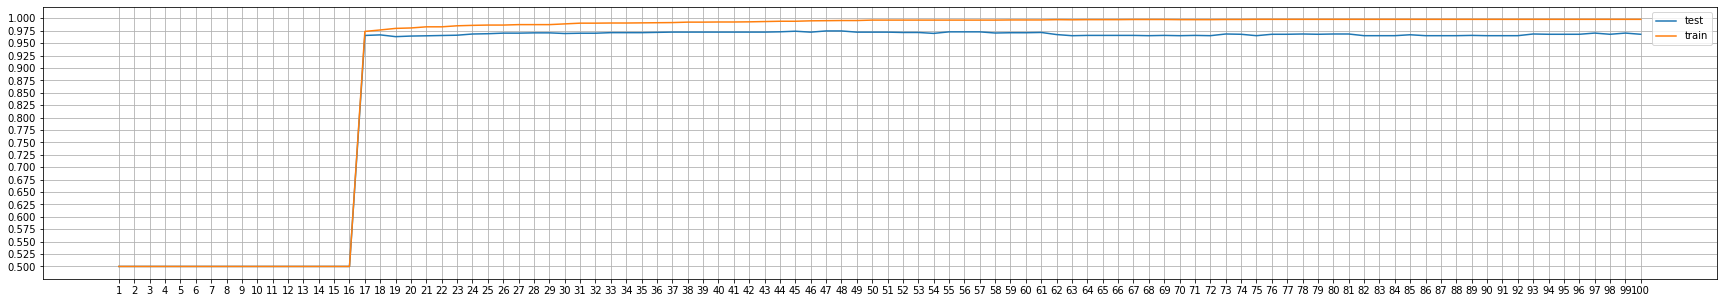

In [9]:
import xgboost as xgb
param = {'max_depth': 4, 'subsample': 0.8, 'eta': 0.03, 'objective':'binary:hinge' }
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

def xgb_cv(param, num_round):
  results = xgb.cv(param, dtrain, num_round, metrics='auc')
  results.index += 1
  max_id = results['test-auc-mean'].idxmax()
  print("Max at:", max_id, "\n", results.loc[max_id])
  plt.figure(figsize=(30, 5))
  plt.plot(results['test-auc-mean'], label="test")
  plt.plot(results['train-auc-mean'], label="train")
  plt.xticks(np.arange(1, num_round + 1, 1))
  plt.yticks(np.arange(0.5, 1.025, 0.025))
  plt.legend()
  plt.grid()
  plt.show()
  return max_id

num_round = xgb_cv(param, 100)

Find optimum `max_depth`

In [10]:
from bayes_opt import BayesianOptimization

def xgb_auc(**kwargs):
    params = {**param, **kwargs}
    params['max_depth'] = int(params['max_depth'])
    results = xgb.cv(params, dtrain, num_round, metrics='auc')
    return results.iloc[-1]['test-auc-mean']

init_points=100
n_iter=50

hyperparameter_space = {
    'max_depth': (2, 20)
}

optimizer = BayesianOptimization(f=xgb_auc,
                                 pbounds=hyperparameter_space,
                                 random_state=1,
                                 verbose=1)

optimizer.maximize(init_points, n_iter)

|   iter    |  target   | max_depth |
-------------------------------------
|  4        |  0.9727   |  7.442    |
|  5        |  0.9745   |  4.642    |
|  7        |  0.9745   |  5.353    |


Find optimum `min_child_weight`, `gamma`

In [11]:
param = {
    **param,
    'max_depth': int(optimizer.max['params']['max_depth'])
}

hyperparameter_space = {
    'min_child_weight': (0, 3),
    'gamma': (0, 3)
}

optimizer = BayesianOptimization(f=xgb_auc,
                                 pbounds=hyperparameter_space,
                                 random_state=1,
                                 verbose=1)

optimizer.maximize(init_points, n_iter)

|   iter    |  target   |   gamma   | min_ch... |
-------------------------------------------------
|  2        |  0.9745   |  0.000343 |  0.907    |
|  81       |  0.9752   |  0.7195   |  1.481    |


Max at: 46 
 train-auc-mean    0.995198
train-auc-std     0.002206
test-auc-mean     0.975188
test-auc-std      0.005334
Name: 46, dtype: float64


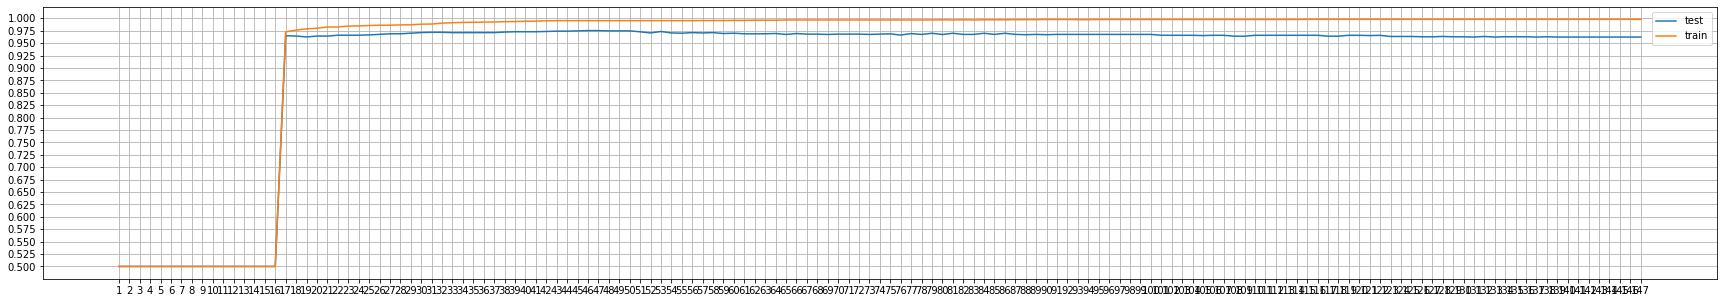

In [12]:
param = {
    **param,
    'min_child_weight': optimizer.max['params']['min_child_weight'],
    'gamma': optimizer.max['params']['gamma']
}

num_round = xgb_cv(param, num_round+100)

Find optimum `subsample`, `colsample_bytree`, `alpha`

In [13]:
from bayes_opt import BayesianOptimization

hyperparameter_space = {
    'subsample': (0.6, 0.9),
    'colsample_bytree': (0.6, 0.9),
    'alpha': (0, 0.05)
}

optimizer = BayesianOptimization(f=xgb_auc,
                                 pbounds=hyperparameter_space,
                                 random_state=1,
                                 verbose=1)

optimizer.maximize(init_points, n_iter)

|   iter    |  target   |   alpha   | colsam... | subsample |
-------------------------------------------------------------
|  2        |  0.9721   |  0.01512  |  0.644    |  0.6277   |
|  3        |  0.974    |  0.009313 |  0.7037   |  0.719    |
|  4        |  0.9758   |  0.02694  |  0.7258   |  0.8056   |
|  8        |  0.9769   |  0.04841  |  0.694    |  0.8077   |
|  135      |  0.9787   |  0.04998  |  0.6917   |  0.8068   |


Max at: 95 
 train-auc-mean    0.992242
train-auc-std     0.003242
test-auc-mean     0.978839
test-auc-std      0.004594
Name: 95, dtype: float64


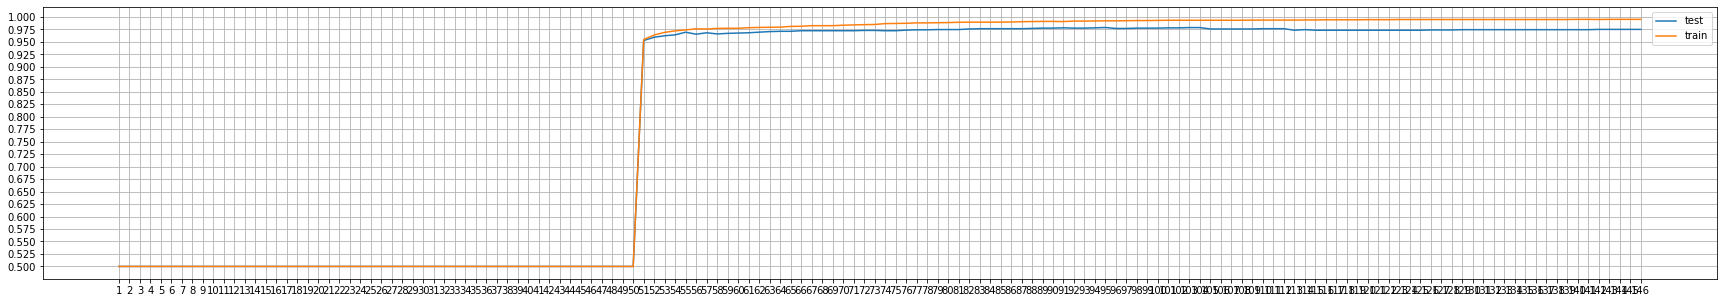

In [14]:
param = {
    **param,
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'alpha': optimizer.max['params']['alpha'],
    'eta': 0.01
}

num_round = xgb_cv(param, num_round+100)

{'max_depth': 5, 'subsample': 0.8068295527425967, 'eta': 0.01, 'objective': 'binary:hinge', 'min_child_weight': 1.48130914280619, 'gamma': 0.7195432774427585, 'colsample_bytree': 0.6916972094778794, 'alpha': 0.04998094719100861}


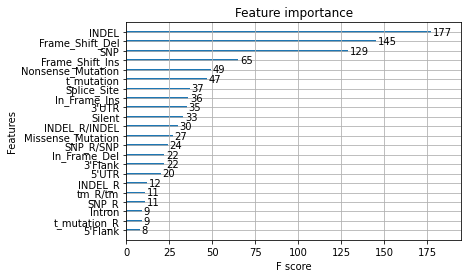

In [15]:
print(param)
clf = xgb.train(param, dtrain, num_round)
xgb.plot_importance(clf);

## Testing

In [16]:
display(HTML('<h2>MSIpred</h2>'))
print(classification_report(y_test, MSIpred_pipe.predict(X_test), digits=4))
display(HTML('<h2>My model</h2>'))
print(classification_report(y_test, clf.predict(dtest), digits=4))

              precision    recall  f1-score   support

           0     0.9890    1.0000    0.9945       270
           1     1.0000    0.9659    0.9827        88

    accuracy                         0.9916       358
   macro avg     0.9945    0.9830    0.9886       358
weighted avg     0.9917    0.9916    0.9916       358



              precision    recall  f1-score   support

           0     0.9888    0.9778    0.9832       270
           1     0.9341    0.9659    0.9497        88

    accuracy                         0.9749       358
   macro avg     0.9614    0.9718    0.9665       358
weighted avg     0.9753    0.9749    0.9750       358



## Non-TCGA testing

In [0]:
url_non_tcga = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM3_ESM.csv"
data_non_tcga = pd.read_csv(url_non_tcga)
data_non_tcga['MSI_Class'] = data_non_tcga['MSI_STATUS'].map({'MSS': 0, 'MSI-H': 1})
X_non_tcga = data_non_tcga.iloc[:, 1:23].fillna(0)
y_non_tcga = data_non_tcga.MSI_Class
dtest_non_tcga = xgb.DMatrix(X_non_tcga)

In [18]:
display(HTML('<h2>MSIpred</h2>'))
print(classification_report(y_non_tcga, MSIpred_pipe.predict(X_non_tcga), digits=4))
display(HTML('<h2>My model</h2>'))
print(classification_report(y_non_tcga, clf.predict(dtest_non_tcga), digits=4))

              precision    recall  f1-score   support

           0     0.9399    0.9900    0.9643       300
           1     0.9595    0.7889    0.8659        90

    accuracy                         0.9436       390
   macro avg     0.9497    0.8894    0.9151       390
weighted avg     0.9444    0.9436    0.9416       390



              precision    recall  f1-score   support

           0     0.9671    0.9800    0.9735       300
           1     0.9302    0.8889    0.9091        90

    accuracy                         0.9590       390
   macro avg     0.9487    0.9344    0.9413       390
weighted avg     0.9586    0.9590    0.9586       390



## Outer CV

Using repeated training-test split (Monte Carlo cross-validation) through `sklearn.model_selection.ShuffleSplit`

In [0]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1000, test_size=.25, random_state=0)

report_metrics = ["precision", "specificity", "sensitivity", "f1", "accuracy"]
def add_report(reports, estimator, X, y):
  report = classification_report(y, estimator.predict(X), digits=4, output_dict=True)
  reports.append((
      report['1']['precision'],
      report['0']['recall'],
      report['1']['recall'],
      report['1']['f1-score'],
      report['accuracy']
  ))

MSIpred_reports = []
clf_reports = []
MSIpred_reports_2 = []
clf_reports_2 = []

for train_i, test_i in rs.split(X):
  X_train, y_train = X.loc[train_i], y.loc[train_i]
  X_test, y_test = X.loc[test_i], y.loc[test_i]

  X_train = X_train.drop('Project', 1)
  X_test = X_test.drop('Project', 1)

  MSIpred_pipe.fit(X_train, y_train)

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test)
  clf = xgb.train(param, dtrain, num_round)

  # TCGA
  add_report(MSIpred_reports, MSIpred_pipe, X_test, y_test)
  add_report(clf_reports, clf, dtest, y_test)

  # Non-TCGA
  add_report(MSIpred_reports_2, MSIpred_pipe, X_non_tcga, y_non_tcga)
  add_report(clf_reports_2, clf, dtest_non_tcga, y_non_tcga)

MSIpred_reports = np.array(MSIpred_reports)
clf_reports = np.array(clf_reports)
MSIpred_reports_2 = np.array(MSIpred_reports_2)
clf_reports_2 = np.array(clf_reports_2)

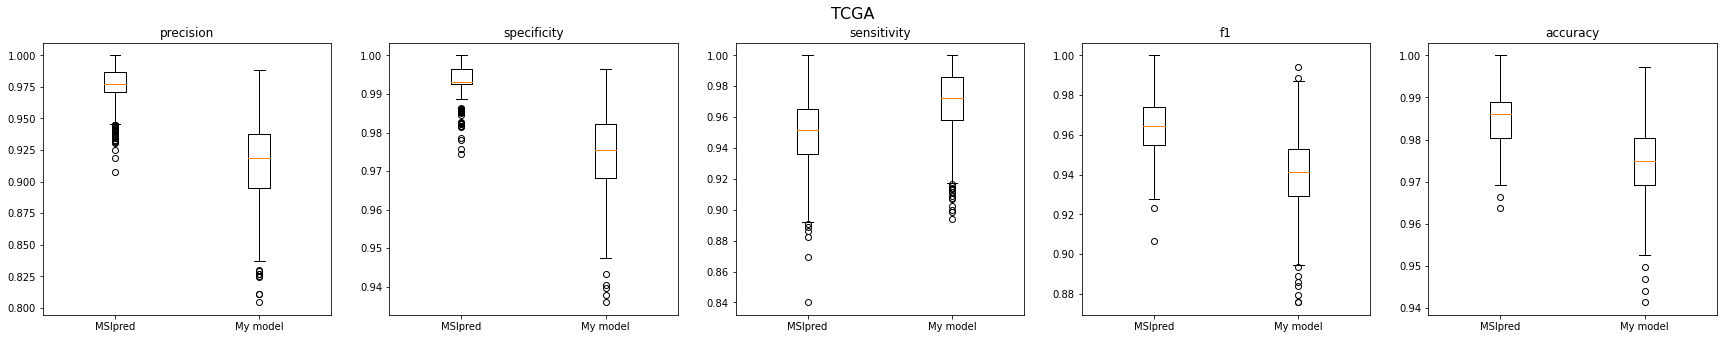

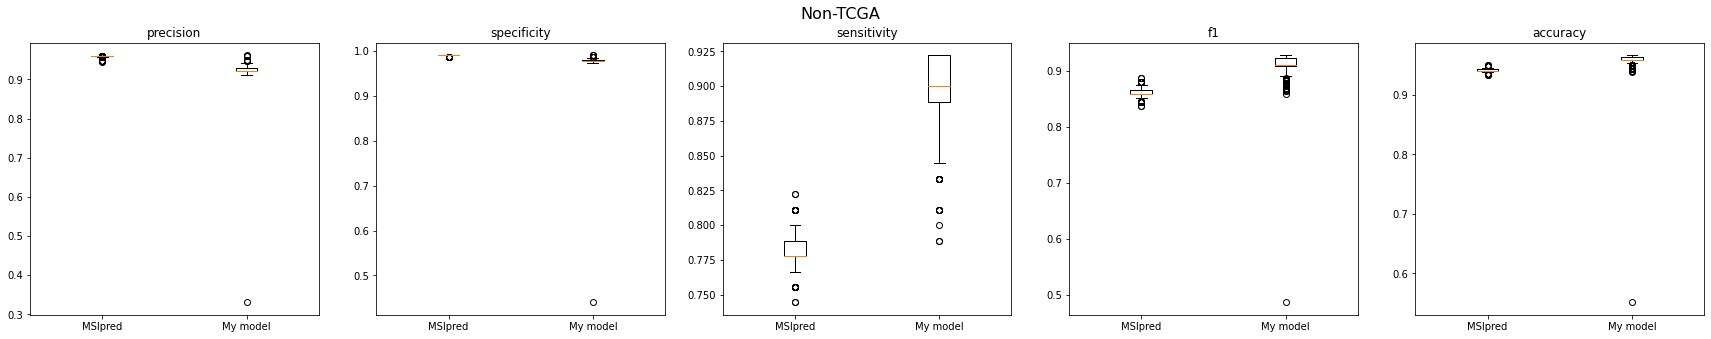

In [20]:
plt.figure(figsize=(30, 5)).suptitle("TCGA", fontsize=16)
for i, metric in enumerate(report_metrics):
  plt.subplot(151+i, title=metric, label=metric)
  plt.boxplot([MSIpred_reports[:, i], clf_reports[:, i]], labels=['MSIpred', 'My model'])

plt.figure(figsize=(30, 5)).suptitle("Non-TCGA", fontsize=16)
for i, metric in enumerate(report_metrics):
  plt.subplot(151+i, title=metric, label=metric)
  plt.boxplot([MSIpred_reports_2[:, i], clf_reports_2[:, i]], labels=['MSIpred', 'My model'])